# Import Libraries

In [45]:
!pip install scikit-fuzzy
import gym
import math
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import numpy as np
from skfuzzy import control as ctrl

# Showing the environment

In [46]:
env = gym.make('Pendulum-v1', render_mode='human') # making the env
observation = env.reset() # for starting at the initial state

for i in range(500):
    env.render()
    action = env.action_space.sample()
    step_result = env.step(action)
    observation, reward, done, info = step_result[:4]
    if done:
        break

env.close()

# Linguistic Variables

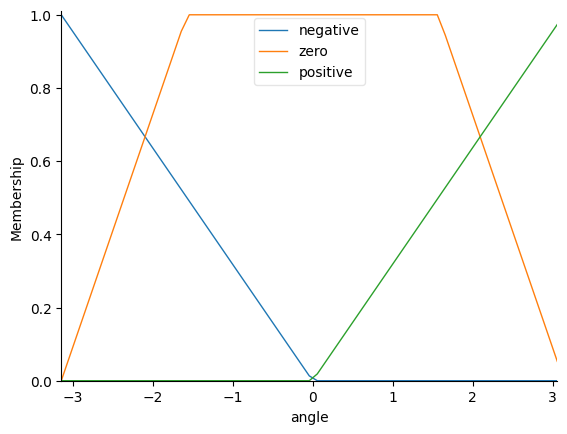

In [47]:
# angle
angle = ctrl.Antecedent(np.arange(-np.pi, np.pi, 0.1), 'angle')
angle['negative'] = fuzz.trimf(angle.universe, [-np.pi, -np.pi, 0])
angle['zero'] = fuzz.trapmf(angle.universe, [-np.pi, -np.pi / 2, np.pi / 2, np.pi])
angle['positive'] = fuzz.trimf(angle.universe, [0, np.pi, np.pi])

angle.view()

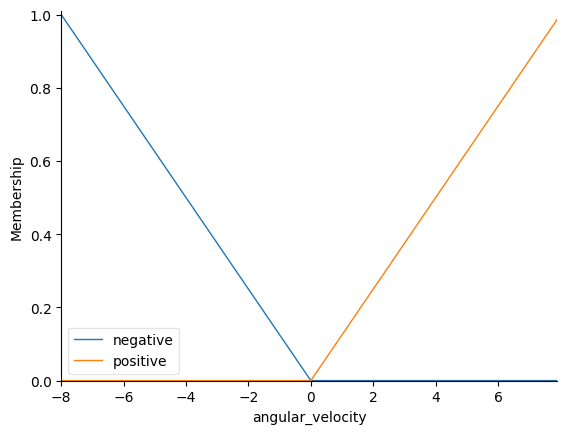

In [48]:
# angle velocity
angular_velocity = ctrl.Antecedent(np.arange(-8, 8, 0.1), 'angular_velocity')
angular_velocity['negative'] = fuzz.trimf(angular_velocity.universe, [-8, -8, 0])
angular_velocity['positive'] = fuzz.trimf(angular_velocity.universe, [0, 8, 8])

angular_velocity.view()

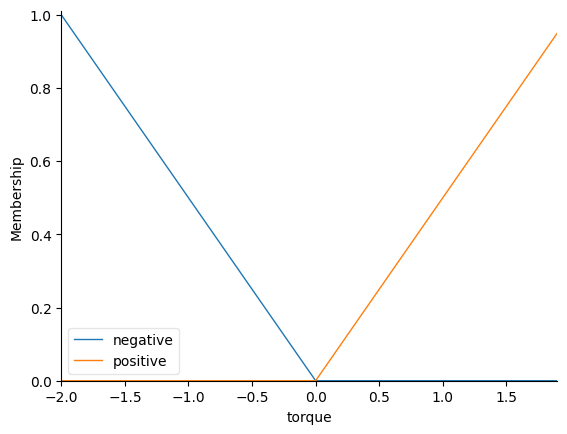

In [49]:
# torque(output)
torque = ctrl.Consequent(np.arange(-2, 2, 0.1), 'torque')
torque['negative'] = fuzz.trimf(torque.universe, [-2, -2, 0])
torque['positive'] = fuzz.trimf(torque.universe, [0, 2, 2])

torque.view()

# Rules

In [50]:
rule1 = ctrl.Rule(antecedent=(angle['positive'] & angular_velocity['negative']), consequent=torque['negative'])
rule2 = ctrl.Rule(antecedent=(angle['positive'] & angular_velocity['positive']), consequent=torque['positive'])
rule3 = ctrl.Rule(antecedent=(angle['negative'] & angular_velocity['positive']), consequent=torque['positive'])
rule4 = ctrl.Rule(antecedent=(angle['negative'] & angular_velocity['negative']), consequent=torque['negative'])
rule5 = ctrl.Rule(antecedent=(angle['zero'] & angular_velocity['positive']), consequent=torque['negative'])
rule6 = ctrl.Rule(antecedent=(angle['zero'] & angular_velocity['negative']), consequent=torque['positive'])

# Control System & Simulator

In [51]:
controller = ctrl.ControlSystem(rules=[rule1, rule2, rule3, rule4, rule5, rule6])
simulator = ctrl.ControlSystemSimulation(controller)

# Finding Angle

In [52]:
def angle_finder(x, y):
    radian_degree = math.atan(x / y)
    if y < 0 and x > 0:
        radian_degree += np.pi
    if y < 0 and x < 0:
        radian_degree -= np.pi

    result = 0
    if -np.pi / 2 <= radian_degree:
        result = radian_degree - np.pi / 2
    if -np.pi <= radian_degree <= -np.pi / 2:
        result = radian_degree + 3 * np.pi / 2
    return result

# Compiling

In [53]:
env = gym.make('Pendulum-v1', render_mode='human') # making the env
observation = env.reset() # for starting at the initial state
rewards = []

for i in range(500):
    x = observation[0]
    y = observation[1]
    # give input to fuzzy lingustic variable:
    simulator.input['angle'] = angle_finder(x , y)
    simulator.input['angular_velocity'] = observation[2]

    simulator.compute() # compute result using fuzzy:
    decision = simulator.output['torque']
    observation, reward, terminated, info = env.step([decision])
    rewards.append(reward)
    if observation[0] >= 0.99 and math.fabs(observation[2]) <= 1.5:
        terminated = True

    env.render()
    # when is done:
    if terminated:
        print(f'we win in {i} iterations!')
        break

env.close()

we win in 197 iterations!


# Ploting the result

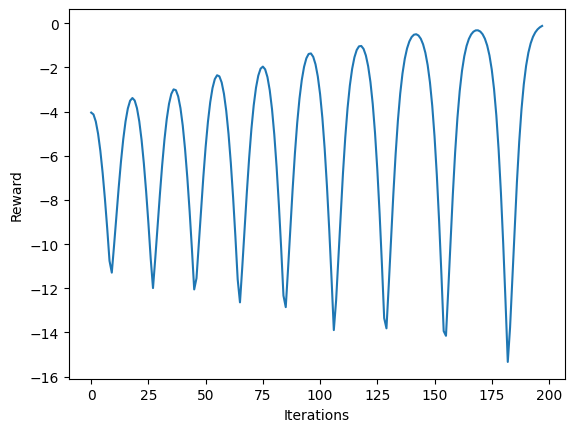

In [54]:
plt.plot(rewards)
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.show()